# Lecture 12
_____________


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import cvxpy as cvx
import seaborn as sns
sns.set_style('whitegrid')

## _Reservoir control - limited foresight_

We're using 12-month foresight

In [5]:
Q = np.loadtxt('data/FOL-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1])
T = len(Q)

K = 975 # reservoir capacity
h = 12 # foresight horizon (months) MUST divide evenly into T
d = 150*np.ones(h) # target demand (TAF/month)

Empty arrays to be filled in

In [6]:
x_save = np.zeros(T+1) # storage
u_save = np.zeros(T) # release
shortage_save = np.zeros(T) # shortage

Loop over time horizons, run optimization, save results in array

In [7]:
for i in range(0,T,h): # zero to T in steps of h
    
    x = cvx.Variable(h+1) # we'll have 13 storages b/c last on needs to be included
    u = cvx.Variable(h)
    
    # objective function
    # subtract the storage to incentivize saving water
    obj = cvx.Minimize(cvx.sum((cvx.pos(d - u))**2) - x[h])
    
    # initial condition
    if i==0:
        ic = K/2
    else:
        ic = x_save[i] # grab initial condition from saved storage from previous optimization
    
    # constraints (define separately, then concatenate the lists)
    c_mass_balance = [x[1:] == x[:-1] - u + Q[i:i+h]] # state transition
    c_release = [u >= 0] # release lower/upper bounds
    c_storage = [x >= 0, x <= K] # storage lower/upper bounds
    c_init_final = [x[0] == ic, x[h] >= 0]
    constraints = c_mass_balance + c_release + c_storage + c_init_final
    
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver='ECOS')
    
    # now look at the results
    print('Status: %s' % prob.status)
    print('Obj Fun: %f' % obj.value)
    
    # save in big array
    x_save[i:i+h+1] = x.value.flatten() # flatten reduces array to 1-D row vector
    
    if h > 1:
        u_save[i:i+h] = u.value.flatten() # note: don't actually need flatten here
        shortage_save[i:i+h] = (d-u.value.flatten()).clip(0,999) # we clipped b/c we only want positive values
    else:
        u_save[i:i+h] = u.value
        shortage_save[i:i+h] = (d-u.value).clip(0,999)

Status: optimal
Obj Fun: 388.947855
Status: optimal
Obj Fun: 29296.149294
Status: optimal
Obj Fun: -834.181735
Status: optimal
Obj Fun: -739.836032
Status: optimal
Obj Fun: -878.942644
Status: optimal
Obj Fun: -900.818347
Status: optimal
Obj Fun: -588.974212
Status: optimal
Obj Fun: -49.581138
Status: optimal
Obj Fun: 19459.591069
Status: optimal
Obj Fun: -826.350991
Status: optimal
Obj Fun: -943.685124
Status: optimal
Obj Fun: -727.601983
Status: optimal
Obj Fun: -633.921980
Status: optimal
Obj Fun: 2777.259310
Status: optimal
Obj Fun: 75089.709639
Status: optimal
Obj Fun: 30302.948862
Status: optimal
Obj Fun: -934.150578
Status: optimal
Obj Fun: -813.289917
Status: optimal
Obj Fun: -953.368347
Status: optimal
Obj Fun: -693.691402


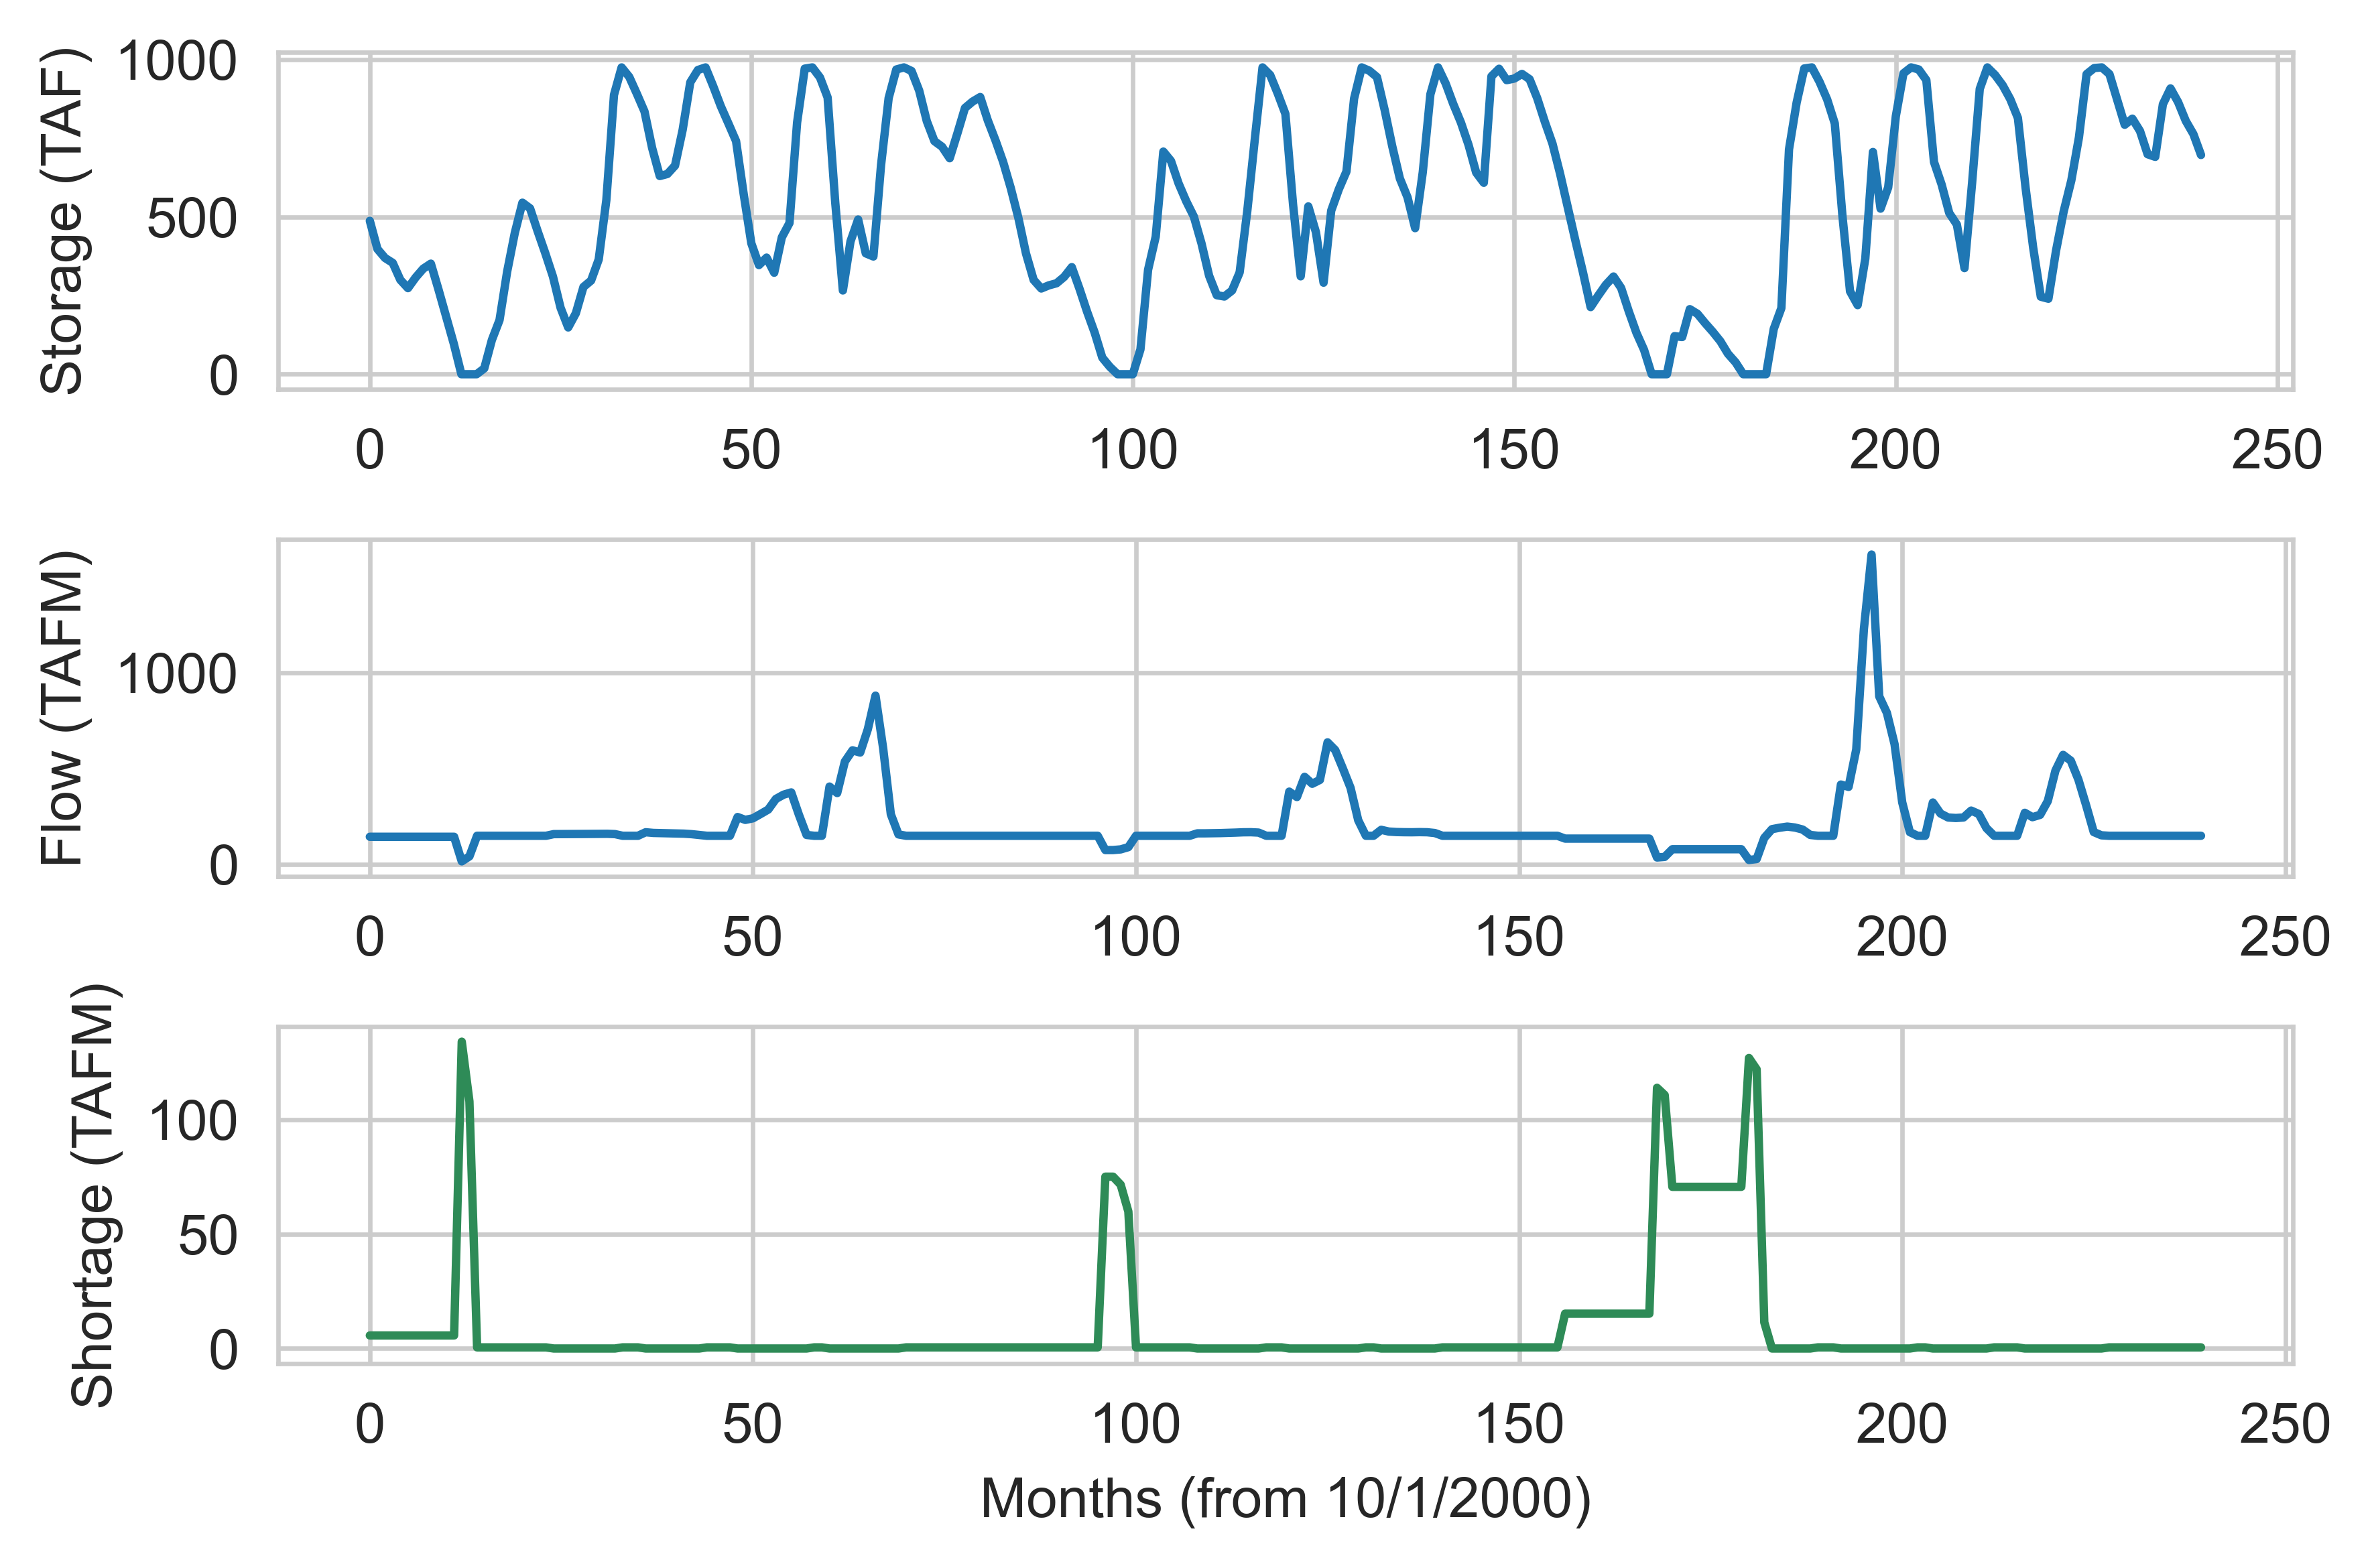

In [8]:
# plot the state variable (storage) and control variable (release)
plt.subplot(3,1,1)
plt.plot(x_save)
plt.ylabel('Storage (TAF)')

plt.subplot(3,1,2)
plt.plot(u_save)
plt.ylabel('Flow (TAFM)')

plt.subplot(3,1,3)
plt.plot(shortage_save, color='seagreen')
plt.ylabel('Shortage (TAFM)')
plt.xlabel('Months (from 10/1/2000)')

plt.tight_layout()
plt.show()

Do we see hedging on the storage-release graph?

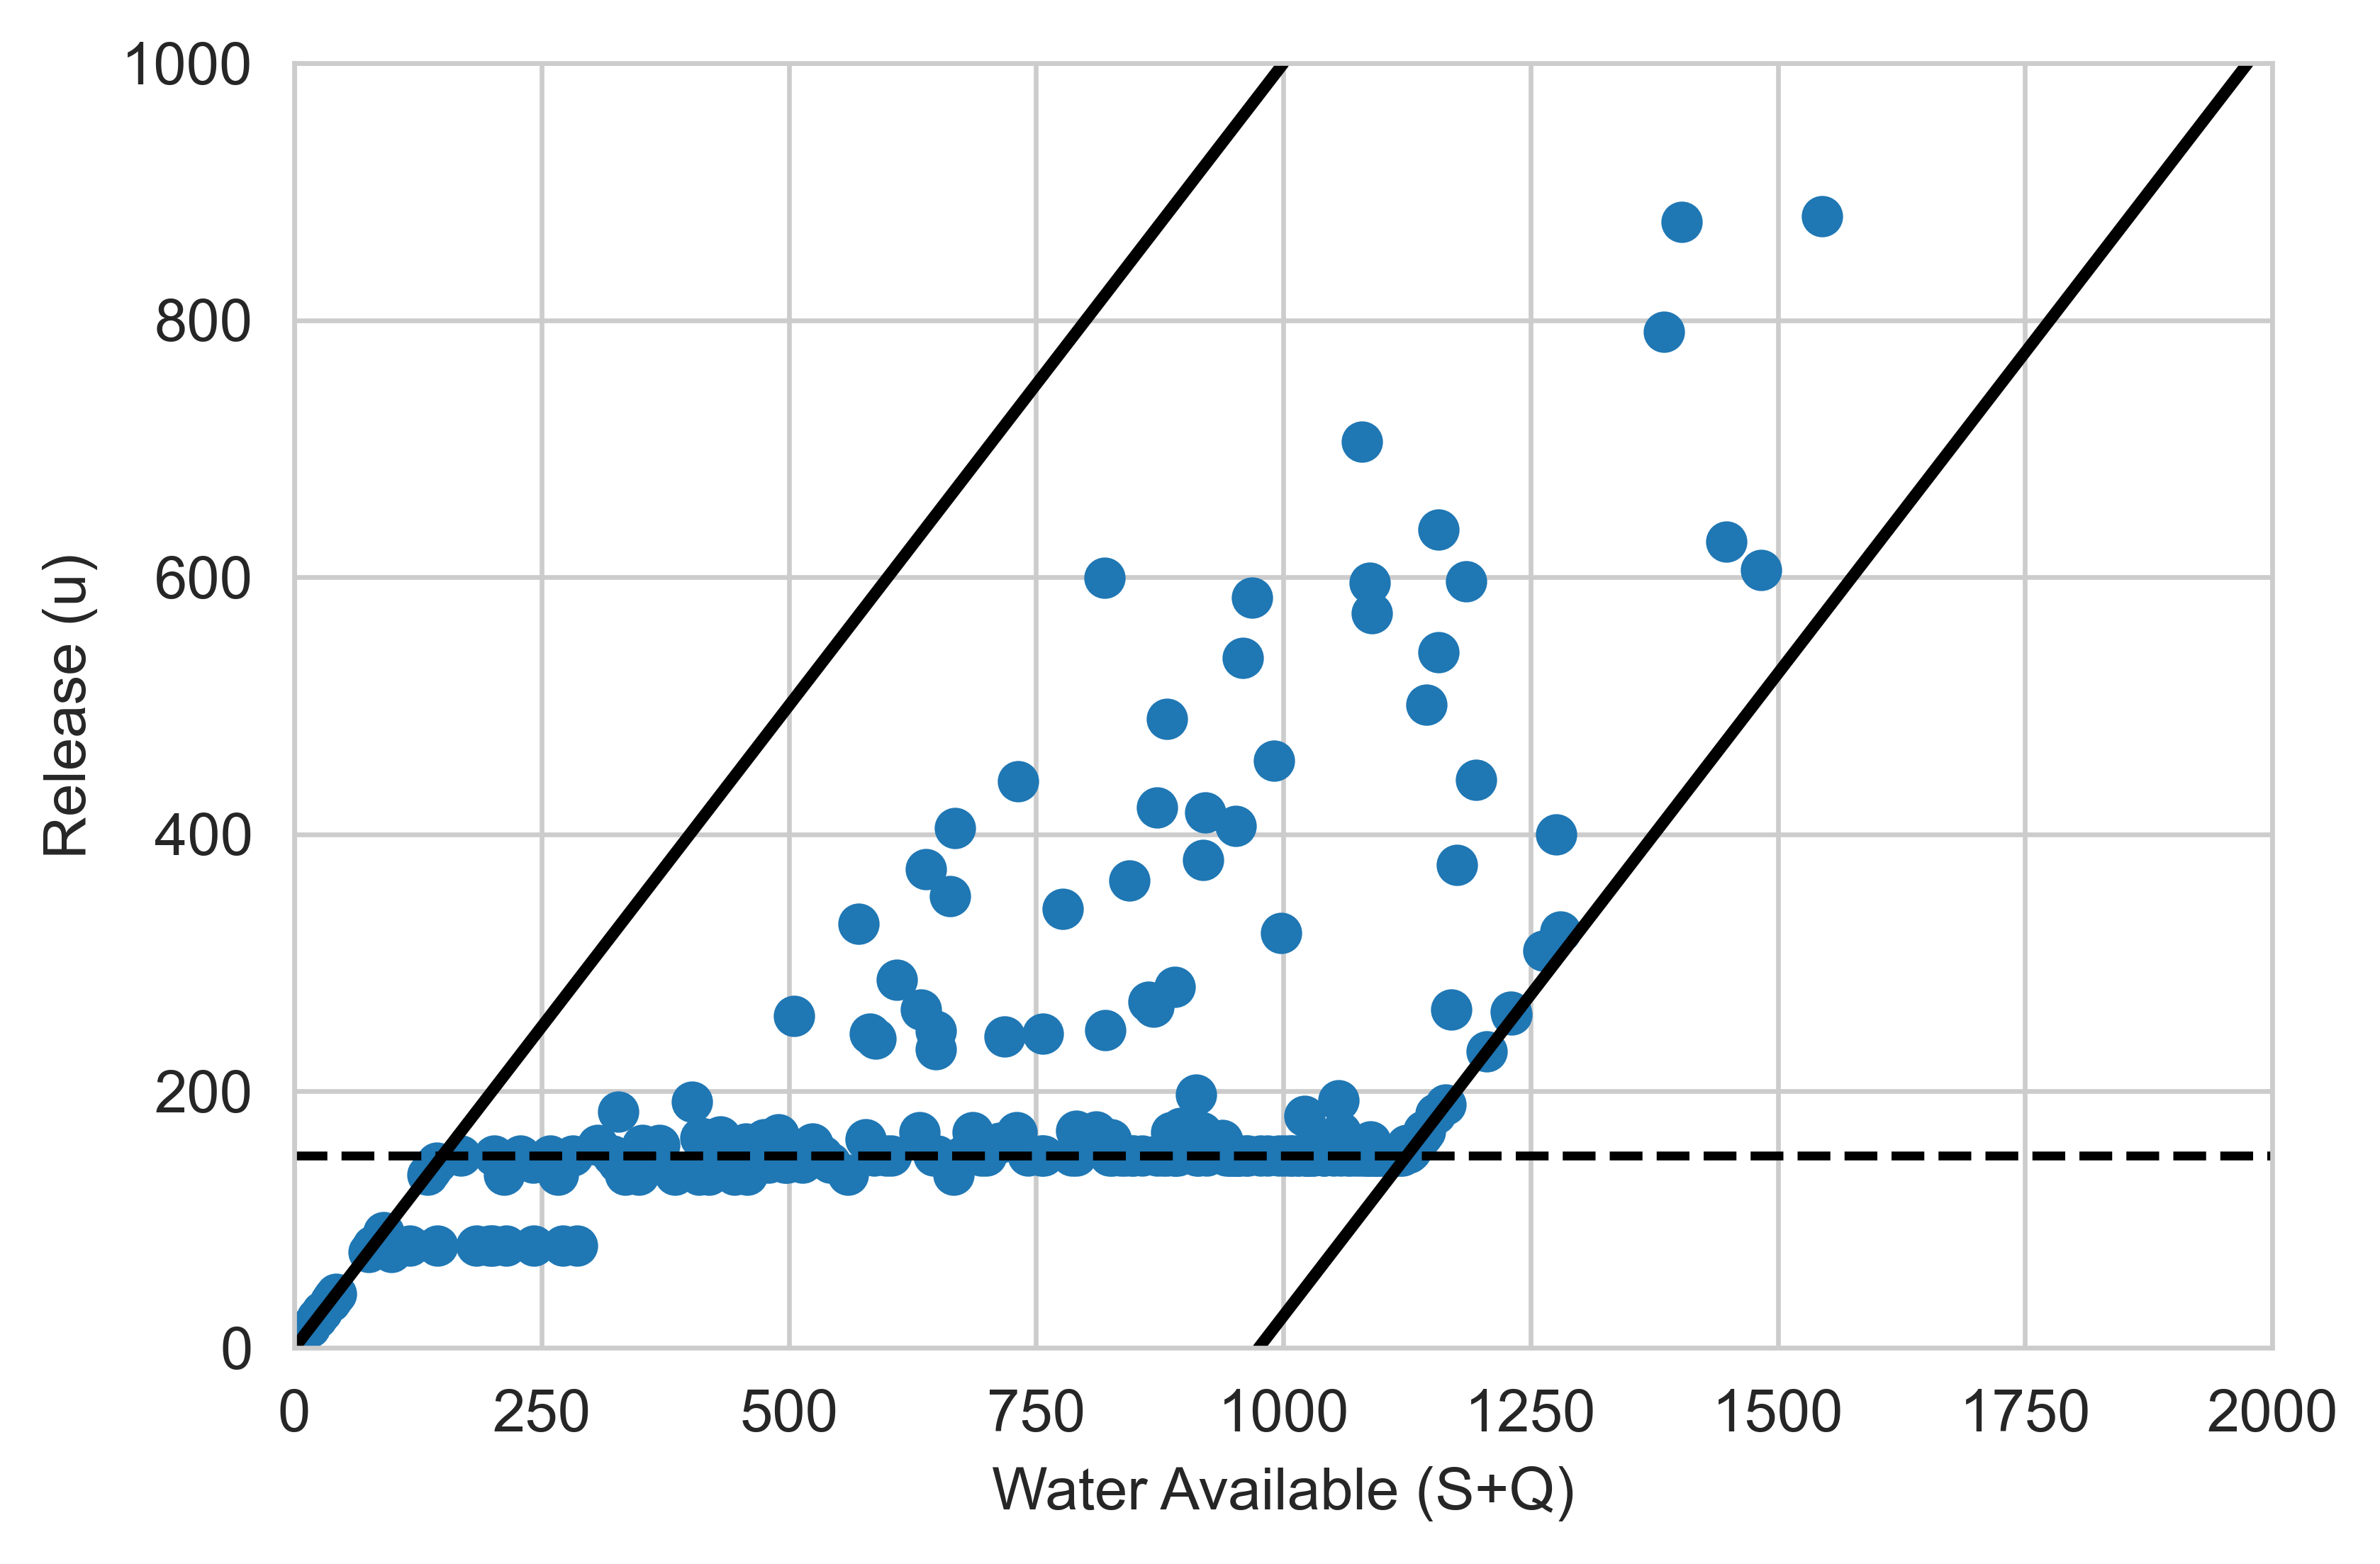

In [9]:
plt.scatter(x_save[:-1]+Q, u_save)
plt.plot([0,1000],[0,1000], color='k', linewidth=2)
plt.plot([975, 975+1000],[0,1000], color='k', linewidth=2)
plt.plot([0,2000],[150,150], '--', color='k')
plt.ylim([0,1000])
plt.xlim([0,2000])
plt.xlabel('Water Available (S+Q)')
plt.ylabel('Release (u)')
plt.show()

-----------

## _Multireservoir optimization_

From Heidari et al. 1971 - 4 reservoirs, 12 time periods

In [10]:
T = 12
X = cvx.Variable((T+1, 4))
U = cvx.Variable((T, 4))

# benefits matrix from paper
B = np.array([[1.1,1.4,1.0,1.0,1.6],
            [1.0,1.1,1.0,1.2,1.7],
            [1.0,1.0,1.2,1.8,1.8],
            [1.2,1.0,1.8,2.5,1.9],
            [1.8,1.2,2.5,2.2,2.0],
            [2.5,1.8,2.2,2.0,2.0],
            [2.2,2.5,2.0,1.8,2.0],
            [2.0,2.2,1.8,2.2,1.9],
            [1.8,2.0,2.2,1.8,1.8],
            [2.2,1.8,1.8,1.4,1.7],
            [1.8,2.2,1.4,1.1,1.6],
            [1.4,1.8,1.1,1.0,1.5]])

# reservoir connectivity matrix
M = np.array([[-1,0,0,0],
             [0,-1,0,0],
             [0,1,-1,0],
             [1,0,1,-1]])

# inflows (constant)
y = np.zeros((T,4))
y[:,0] = 2
y[:,1] = 3

# storage upper bound
XUB = 10*np.ones((T+1,4))
XUB[:,3] = 15
# release upper bound
UUB = 4*np.ones((T,4))
UUB[:,0] = 3
UUB[:,3] = 7

__Objective function__ (hydropower plus ag benefit)

_Note:_ in cvxpy 1.1 and later, they recommend @ symbol for matrix multiplication

If we use * instead it will give a warning

In [11]:
obj = cvx.Maximize(B[:,0].T @ U[:,0] + B[:,1].T @ U[:,1] 
                 + B[:,2].T @ U[:,2] + B[:,3].T @ U[:,3] 
                 + B[:,4].T @ U[:,3])

Mass balance constraint in matrix form

In [12]:
c_mass_balance = [X[1:,:] == X[:-1,:] + y + U @ M.T]
c_nonneg = [U >= 0, X >= 0] # release lower/upper bounds
c_ub = [X <= XUB, U <= UUB]
c_init_final = [X[0,:] == 5, X[T,:] >= np.array([5,5,5,7])]
constraints = c_mass_balance + c_nonneg + c_ub + c_init_final

prob = cvx.Problem(obj, constraints)
prob.solve()

401.29999997582865

In [13]:
print('Status: %s' % prob.status)
print('Obj Fun: %f' % obj.value)

Status: optimal
Obj Fun: 401.300000


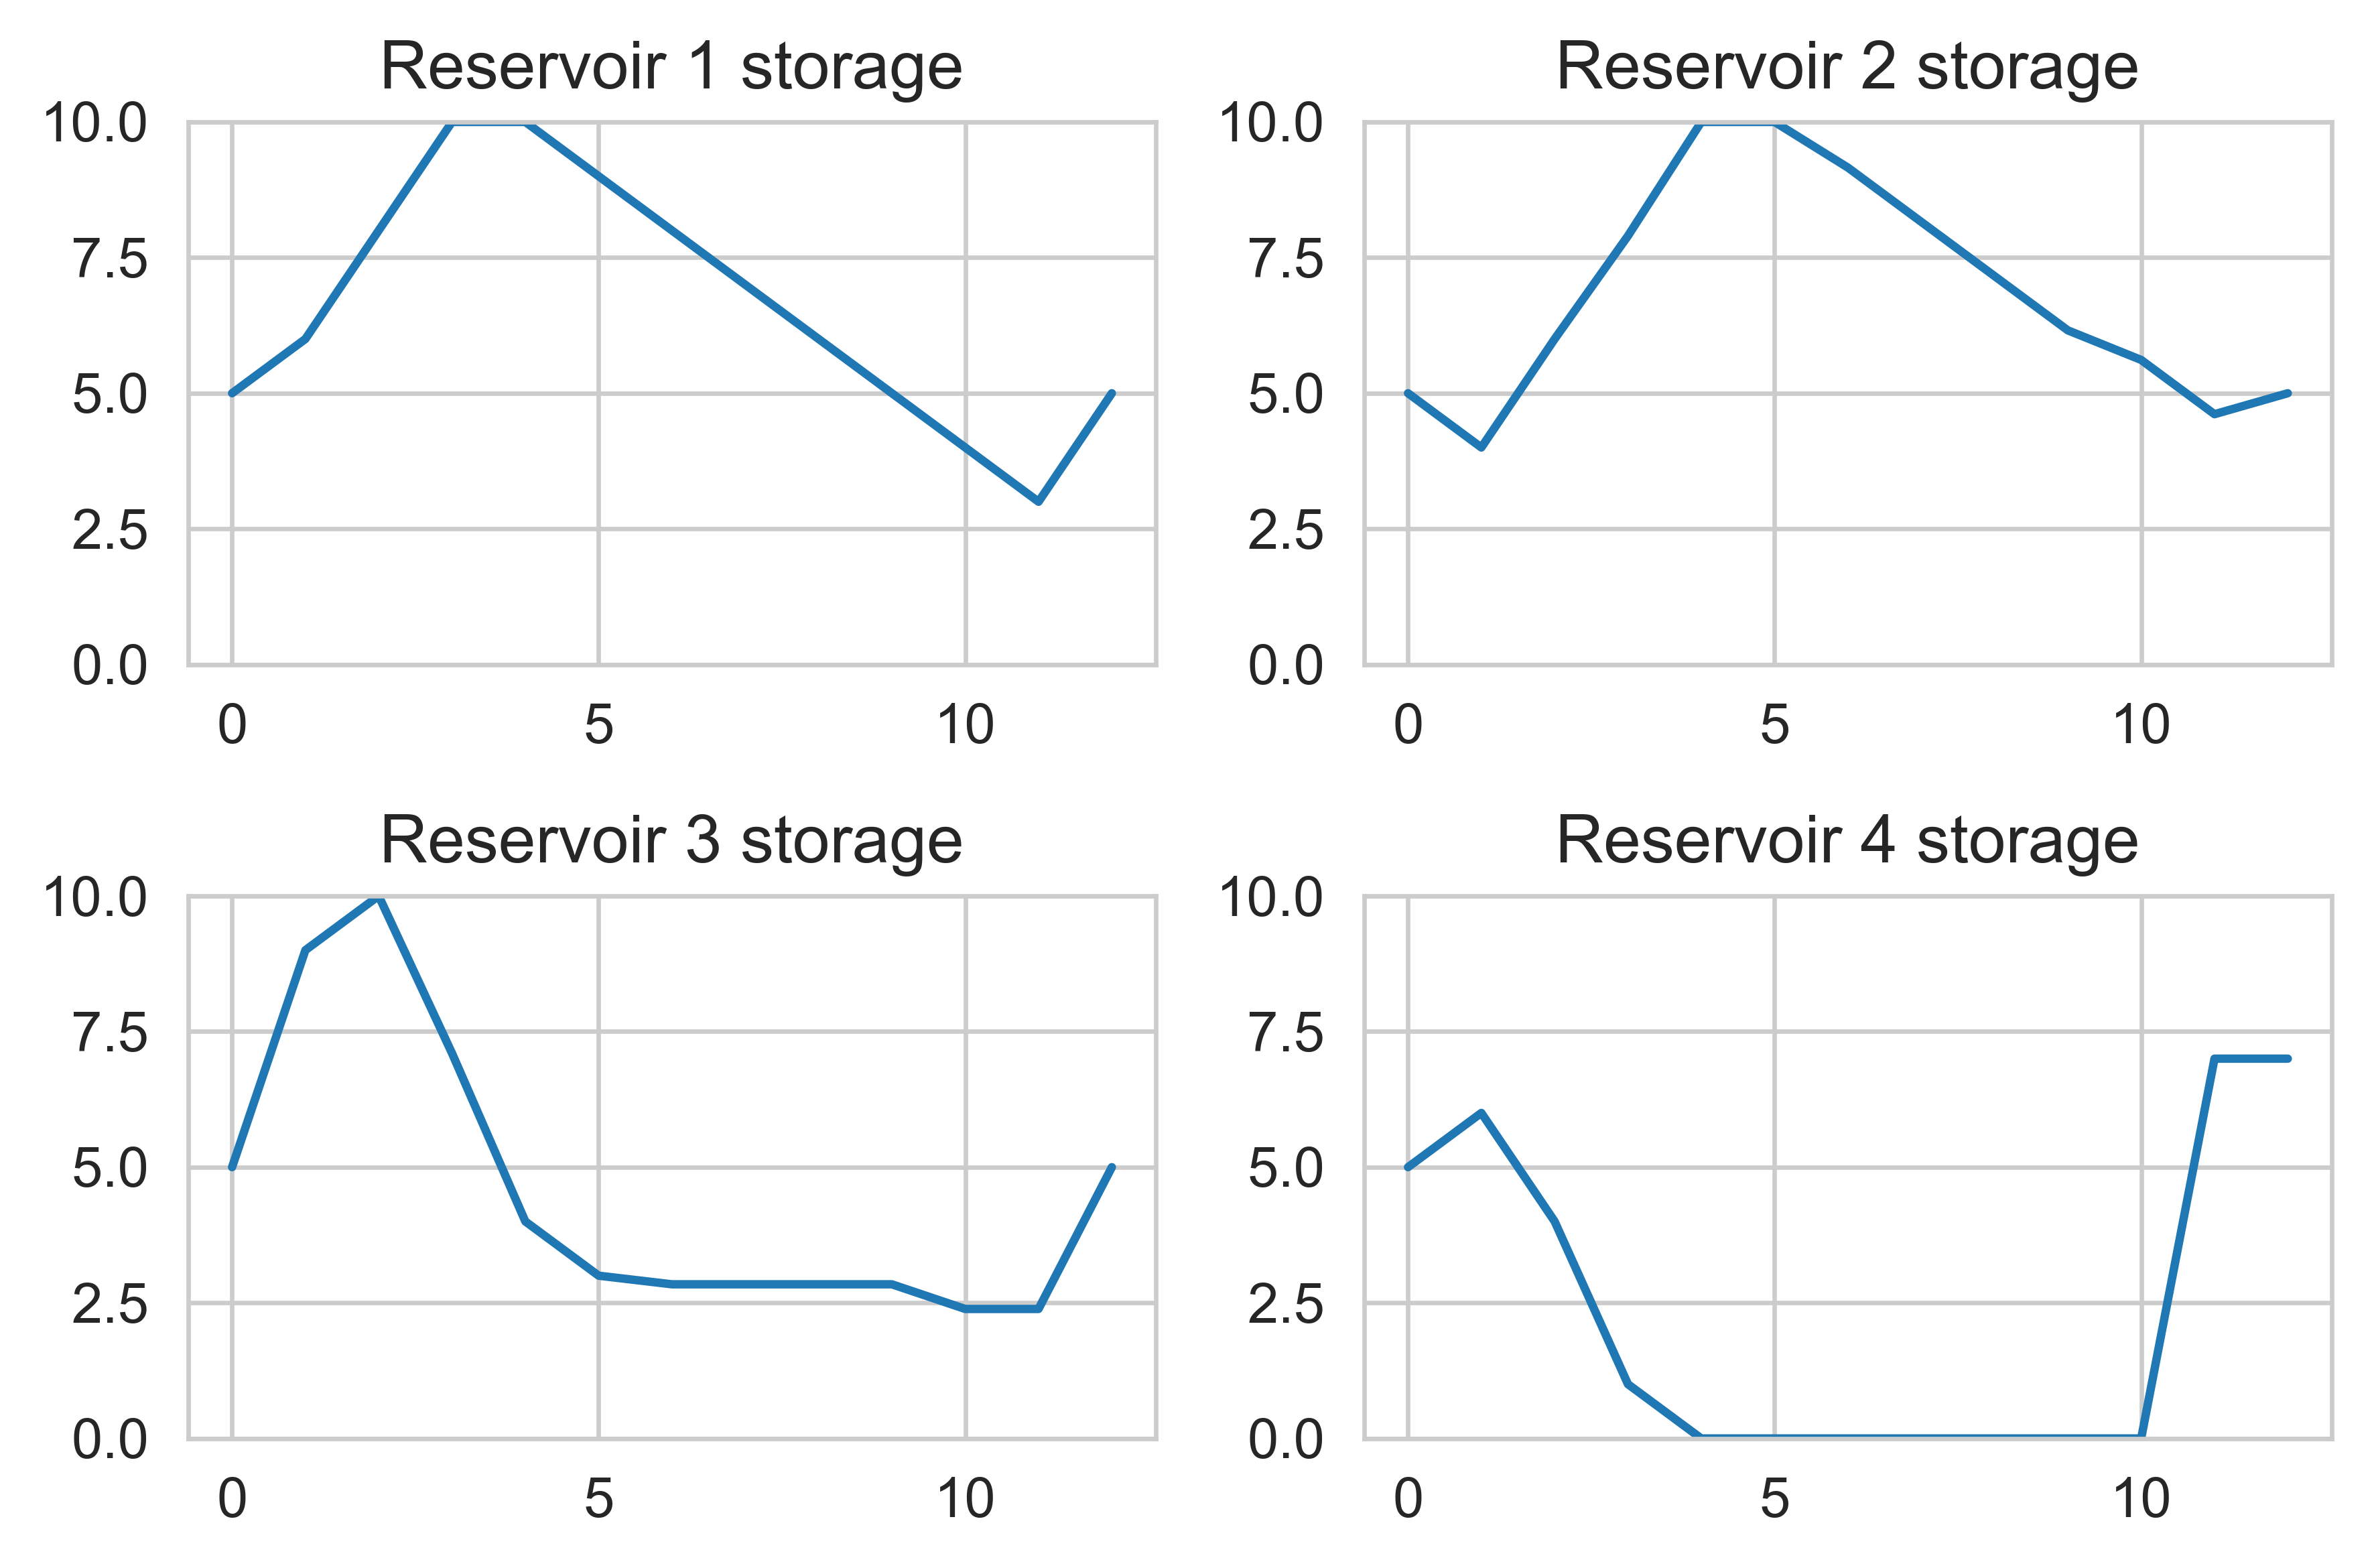

In [15]:
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(X[:,i].value)
  plt.ylim([0,10])
  plt.title('Reservoir %d storage' % (i+1))

plt.tight_layout()
plt.show()

---------------